# GAN Project

I'm not sure exactly what I want to call it yet, but the goal is to make a webapp that uses GANs and Deep Learning to remove artifacts on images the user uploads. I wanted to make this to get some experience working with GANs as I think their applications are endless and really intresting, along with doing some web development that I don't have a ton of experience in.

In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
from fastai.vision import *
from fastai.vision.gan import *

from PIL import Image, ImageDraw, ImageFont

In [53]:
torch.cuda.set_device(0)
print(f"Using GPU {torch.cuda.current_device()}")

Using GPU 0


## Data

I'll start by just focusing on training my GAN on portrait shots of people's faces. To get my dataset, I'll scrape Google Images to get a decent amount of Images, then create "crappy" versions of them from a custom function that my GAN will work on cleaning up and making close to the clean original.

In [186]:
os.makedirs('data/gan_project/normal', exist_ok=True)
os.system("rm -rf data/gan_project/crappy")
os.makedirs('data/gan_project/crappy', exist_ok=True)

PATH = Path('data/gan_project')
NORM = Path(PATH/'normal')
CRAP = Path(PATH/'crappy')

### Scraping Google Images

Downloading Images

In [55]:
# os.system(f"touch {NORM}/image_urls.txt")
file = "image_urls.txt"

In [56]:
download_images(PATH/file, NORM, max_pics=200)

Error https://www.shutterstock.com/blog/wp-content/uploads/sites/5/2015/01/shutterstock_119868463.jpg HTTPSConnectionPool(host='www.shutterstock.com', port=443): Read timed out. (read timeout=4)
Error https://www.shutterstock.com/blog/wp-content/uploads/sites/5/2015/01/shutterstock_119868463.jpg HTTPSConnectionPool(host='www.shutterstock.com', port=443): Read timed out. (read timeout=4)


Remove images that can't be opened

In [57]:
verify_images(NORM, delete=True, max_size=500)

cannot identify image file <_io.BufferedReader name='data/gan_project/normal/00000031.jpg'>


/home/waydegg/anaconda3/envs/fastai-course-v3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


int() argument must be a string, a bytes-like object or a number, not 'tuple'


Convert images to PNG format

In [58]:
for x in os.listdir(NORM):
    if x[-3:] != "png" and x[0] != ".":
        fn = x.split('.')[0]
        img = PIL.Image.open(NORM/x).convert("RGBA")
        img.save(str(NORM/fn) + ".png")
        os.system(f"rm {NORM/x}")

View Images

In [59]:
il = ImageItemList.from_folder(NORM)

In [60]:
il[:5]

ImageItemList (5 items)
[Image (3, 499, 328), Image (3, 281, 500), Image (3, 500, 400), Image (3, 333, 500), Image (3, 345, 499)]...
Path: data/gan_project/normal

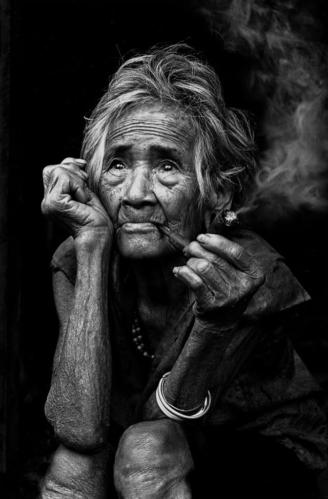

In [61]:
il[0]

### Crappifying Images

I'm stealing this term from Jeremy Howard's method of creating poor-quality images for a GAN to recreate. We need to think about what kind of artifacts are commonly seen in images for deciding how we want to "crappify" the high quality ones pulled from Google Images. Artifacts we may want to consider training the GAN for are:

- Transparent or opaque text
- Repeating pattens
- Low image resolution
- Color corrections

In [62]:
il.items

array([PosixPath('data/gan_project/normal/00000054.png'), PosixPath('data/gan_project/normal/00000183.png'),
       PosixPath('data/gan_project/normal/00000024.png'), PosixPath('data/gan_project/normal/00000145.png'), ...,
       PosixPath('data/gan_project/normal/00000030.png'), PosixPath('data/gan_project/normal/00000098.png'),
       PosixPath('data/gan_project/normal/00000164.png'), PosixPath('data/gan_project/normal/00000105.png')],
      dtype=object)

In [63]:
im_path = str(NORM/os.listdir(NORM)[0])
im_path

'data/gan_project/normal/00000054.png'

Overlays to add:
- 45 degree lines across entire image
- copyright symbol
- text in center and at random points around image
- transparent 'swirl' and 'camera' icons placed around image

In [66]:
img = PIL.Image.open(im_path).convert("RGBA")
h, w = img.size

blank_img = Image.new('RGBA', img.size, (255,255,255,0))
draw_blank = ImageDraw.Draw(blank_img)
# draw_blank.line((0, 0) + img.size, width=5, fill=(255,255,255,50))
# draw_blank.line([(0+100,0),(h+100, w)], width=5, fill=(255,255,255,50))  
# draw_blank.line([(0,0),(h/9, w/9)], width=5, fill=(255,255,255,128))
# draw_blank.line([(h/4, w/4),(h/3,w/3)], width=5, fill=(255,255,255,128))

draw_blank.line([(0,0),(20,20)], width=5, fill=(255,255,255,128))
draw_blank.line([(40,40),(60,60)], width=5, fill=(255,255,255,128))
# draw_blank.arc([(0,0), (100,100)], start=0, end=200, width=3, fill=(255,255,255,128))
# draw_blank.arc([(0,0), (50,50)], start=0, end=200, width=3, fill=(255,255,255,128))

# fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 100)
# draw_blank.text((25,0), text="C", fill=(255,255,255,200), font=fnt)
# draw_blank.arc([(0,0), (100,100)], start=0, end=360, width=3, fill=(255,255,255,128))

line_length = 20
spacing = 20



out = Image.alpha_composite(img, blank_img)
# img.convert("JPEG")
# img.save(CRAP/'test.png')

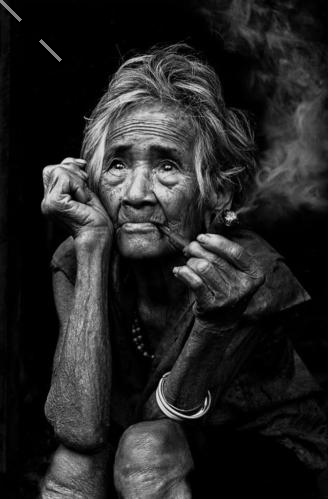

In [67]:
out

In [187]:
def cross(img_path):
    img = PIL.Image.open(img_path).convert("RGBA")
    w,h = img.size

    blank_img = Image.new('RGBA', img.size, (255,255,255,0))
    draw_blank = ImageDraw.Draw(blank_img)
    
    draw_blank.line([(0,0),(w,h)], width=5, fill=(255,255,255,128))
    draw_blank.line([(w,0),(0,h)], width=5, fill=(255,255,255,128))
    
    file_name = img_path.split('/')[-1]
    out = Image.alpha_composite(img, blank_img)
    out.save(CRAP/file_name)
    
    
    return out

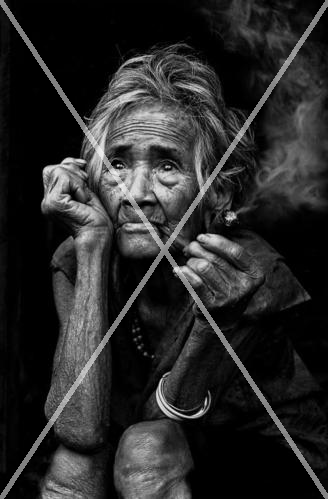

In [188]:
cross(im_path)

In [189]:
def crappify():
    for img in os.listdir(NORM):
        img_path = str(NORM/img)
#         print(img_path)
        cross(img_path)


In [190]:
%%time
# Only call once
crappify()

CPU times: user 12.2 s, sys: 92.7 ms, total: 12.3 s
Wall time: 12.3 s


In [191]:
il = ImageItemList.from_folder(NORM)
il_c = ImageItemList.from_folder(CRAP)

In [192]:
il

ImageItemList (196 items)
[Image (3, 499, 328), Image (3, 281, 500), Image (3, 500, 400), Image (3, 333, 500), Image (3, 345, 499)]...
Path: data/gan_project/normal

## Pretrain Generator

In [193]:
arch = models.resnet34
bs,size = 64, 256
src = ImageImageList.from_folder(CRAP).random_split_by_pct(0.1, seed=42)

In [194]:
# def get_data(bs,size):
#     data = (src.label_from_func(lambda x: NORM/x.name)
#            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
#            .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
#            )
    
#     data.c = 3
#     return data

def get_data(bs,size):
    data = (src.label_from_func(lambda x: NORM/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [195]:
%%time
data_gen = get_data(bs,size)

CPU times: user 13.3 s, sys: 87.9 ms, total: 13.4 s
Wall time: 3.41 s


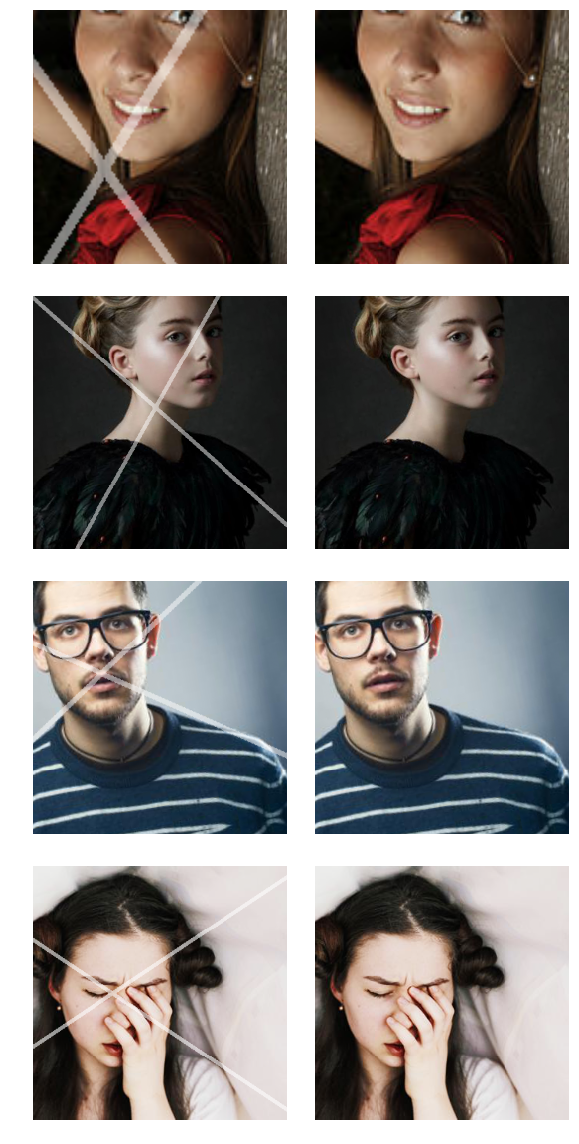

In [196]:
data_gen.show_batch(4)

In [197]:
wd = 1e-3

In [198]:
y_range = (-3., 3.)

In [199]:
loss_gen = MSELossFlat()

In [200]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [201]:
%%time
learn_gen = create_gen_learner()

CPU times: user 1min 49s, sys: 199 ms, total: 1min 49s
Wall time: 15.7 s


In [202]:
learn_gen.fit_one_cycle(10, slice(1e-6,1e-3))

epoch,train_loss,valid_loss


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 10.92 GiB total capacity; 4.25 GiB already allocated; 50.50 MiB free; 179.80 MiB cached)

In [ ]:
learn_gen.show_results(rows=4)